Data Description:  
Accident_ID	=unique id assigned to each row  
Accident_Type_Code=the type of accident (factor, not numeric)  
Cabin_Temperature=the last recorded temperature before the incident, measured in degrees fahrenheit(F)  
Turbulence_In_gforces=the recorded/estimated turbulence experienced during the accident  
Control_Metric=an estimation of how much control the pilot had during the incident given the factors at play  
Total_Safety_Complaints=number of complaints from mechanics prior to the accident  
Days_Since_Inspection=how long the plane went without inspection before the incident  
Safety_Score=a measure of how safe the plane was deemed to be  
Severity=a description (4 level factor) on the severity of the crash [Target]  

In [1]:
import numpy as np
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import cross_val_score,cross_validate 
import matplotlib.pyplot as plt
import seaborn as sns

# from scikitplot.metrics import plot_roc_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as sms
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

In [2]:
df=pd.read_csv('train.csv')
df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [3]:
df.Severity.value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

In [4]:
df.shape

(10000, 12)

In [5]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:22]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int64
Total_Safety_Complaints    10000 non-null int64
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int64
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int64
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 937.6+ KB


In [7]:
df.drop(['Accident_ID'],axis=1,inplace=True)

In [8]:
df.nunique()

Severity                      4
Safety_Score               1175
Days_Since_Inspection        23
Total_Safety_Complaints      44
Control_Metric              952
Turbulence_In_gforces      1117
Cabin_Temperature           950
Accident_Type_Code            7
Max_Elevation              4191
Violations                    6
Adverse_Weather_Metric     4258
dtype: int64

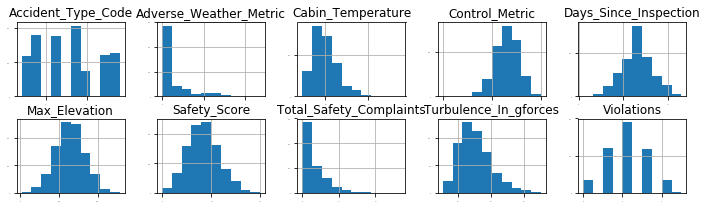

In [9]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12), layout=(7, 5))
plt.show()

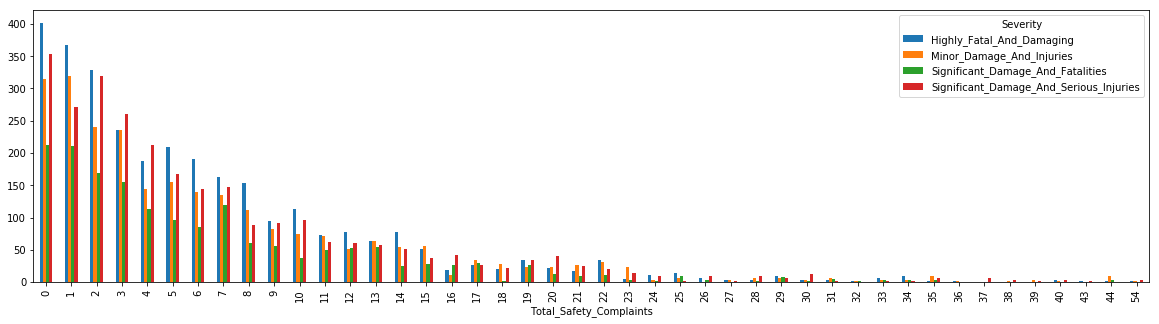

In [10]:
df.groupby(['Total_Safety_Complaints','Severity']).size().unstack().plot(kind='bar',figsize=(20,5))

**Total Safety Complaints= As the number of complains from mechanics increases there is less chance of severity**  
**As the number of complain becomes less there is high chance of severity,i.e.,Highly fatal and damaging**

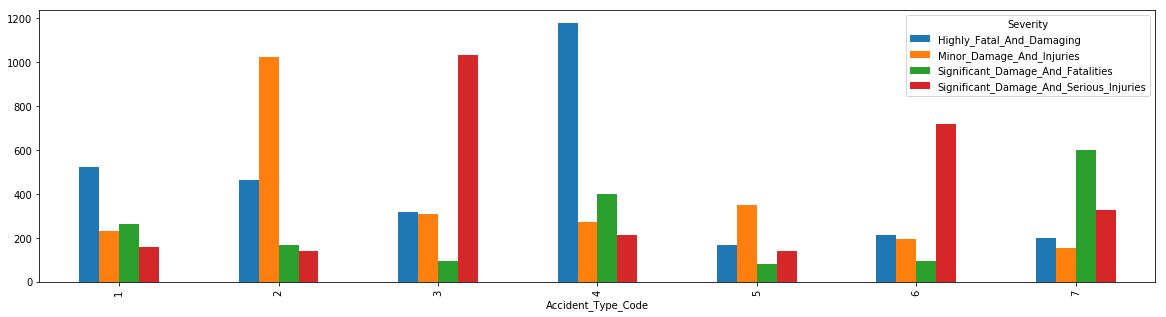

In [11]:
df.groupby(['Accident_Type_Code','Severity']).size().unstack().plot(kind='bar',figsize=(20,5))

**For acc code 1,4 we have highly fatal severity**  
**For acc code 2,5 we have minor fatal severity**  
**For acc code 3,6 we have significant and serious severity**  
**For acc code 7 we have significant damage and fatalities**  
This feature is redundant we will drop this.

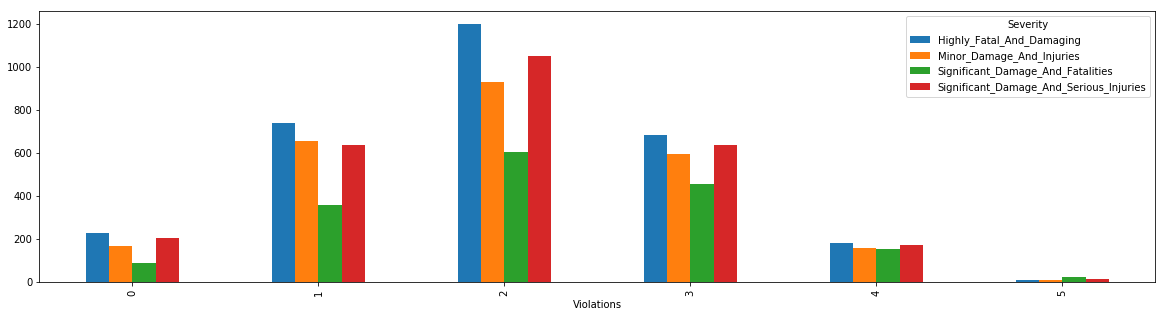

In [12]:
df.groupby(['Violations','Severity']).size().unstack().plot(kind='bar',figsize=(20,5))

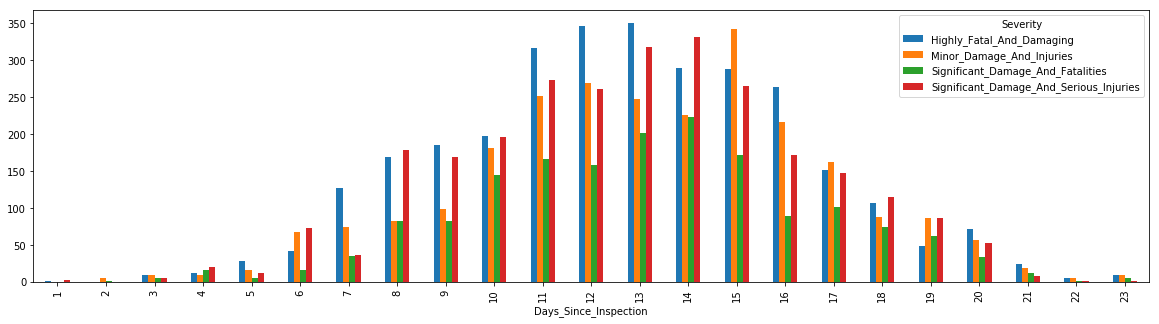

In [13]:
df.groupby(['Days_Since_Inspection','Severity']).size().unstack().plot(kind='bar',figsize=(20,5))

**As the duration of flight inspection increases there is more chance that the severity is Highly fatal and damaging**

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


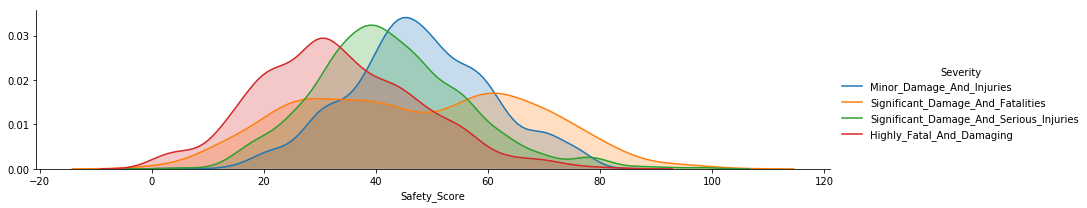

In [14]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Safety_Score', shade=True)
facet.add_legend() 

**As safety score increases the Severity decreases that is there is minor damage and injuries,but when the safety score is low severity is highly fatal nad damaging**

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


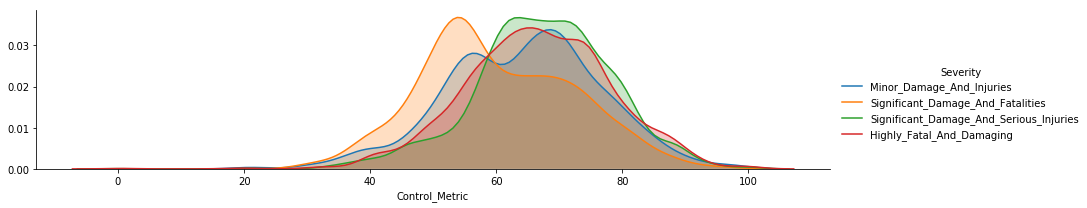

In [15]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Control_Metric', shade=True)
facet.add_legend() 

**Handling quality metrics such as Cooper-Harper Rating (CHR) are pilot-assessed metrics used to evaluate a flight control system performance in the presence of a pilot in the loop.**  
**As this metric increases the severity decreases ,i.e,significant damage and injuries or minor damage and injuries**  
**As this metric increases the severity increases ,i.e,highly fatal and damaging**

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


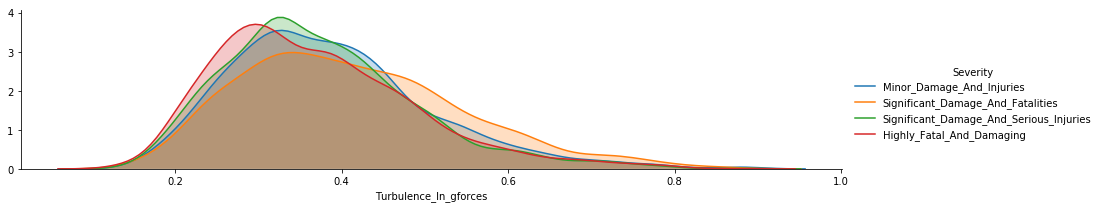

In [16]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Turbulence_In_gforces', shade=True)
facet.add_legend() 

**Turbulence is an irregular motion of the air resulting from eddies and vertical currents. It may be as insignificant as a few annoying bumps or severe enough to momentarily throw an airplane out of control or to cause structural damage. Turbulence is associated with fronts, wind shear, thunderstorms, etc.**  
**Turbulence centered around 0.4 had minor damage or significant damage**  
**Turbulence centered around 0.25 had high severity damage **  
**Turbulence centered around 0.6 had high significant damage and fatalities**  

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


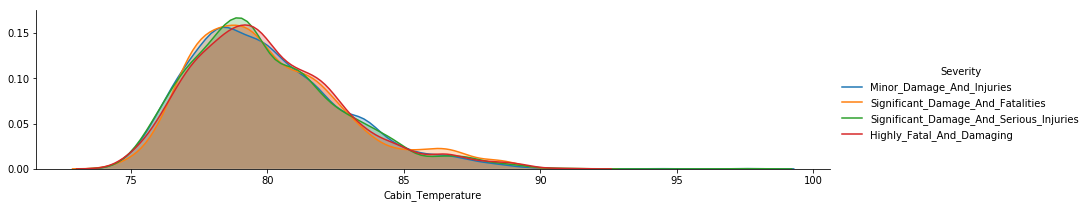

In [17]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Cabin_Temperature', shade=True)
facet.add_legend() 

**Almost every distribution is equal**  
No conclusion

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


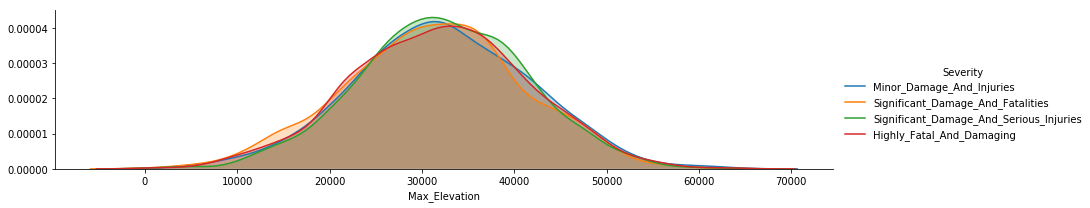

In [18]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Max_Elevation', shade=True)
facet.add_legend() 

**We can infer that the optimal maximum elevation in centered around mean(i.e.,30000)**

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


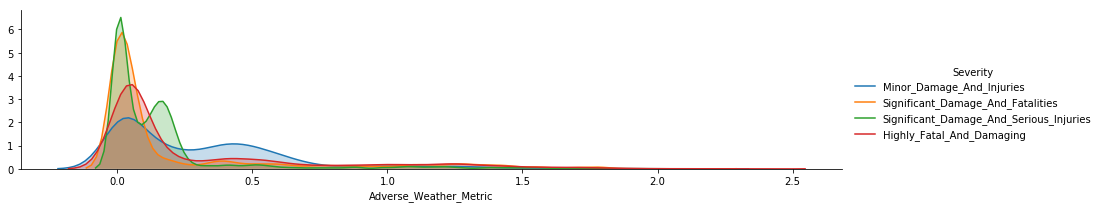

In [19]:
facet = sns.FacetGrid(df, hue = 'Severity', size=3, aspect=4)
facet.map(sns.kdeplot, 'Adverse_Weather_Metric', shade=True)
facet.add_legend() 

**Weather conditions that is 0.0 has significant and serious injuries.**  
**As the weather condition become harsh fatality increases**  

In [20]:
df['Accident_Type_Code'] = df['Accident_Type_Code'].astype(object)
df['Violations'] = df['Violations'].astype(object)

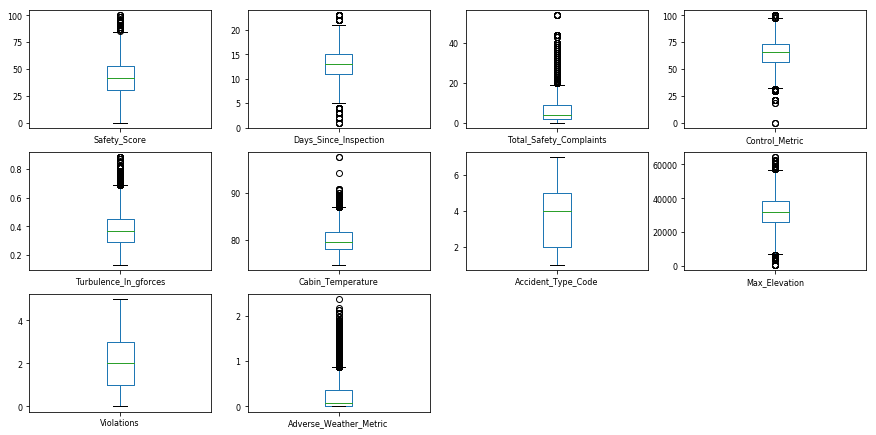

In [21]:
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, legend=True, 
        figsize=(15,10), fontsize=8)
plt.show()

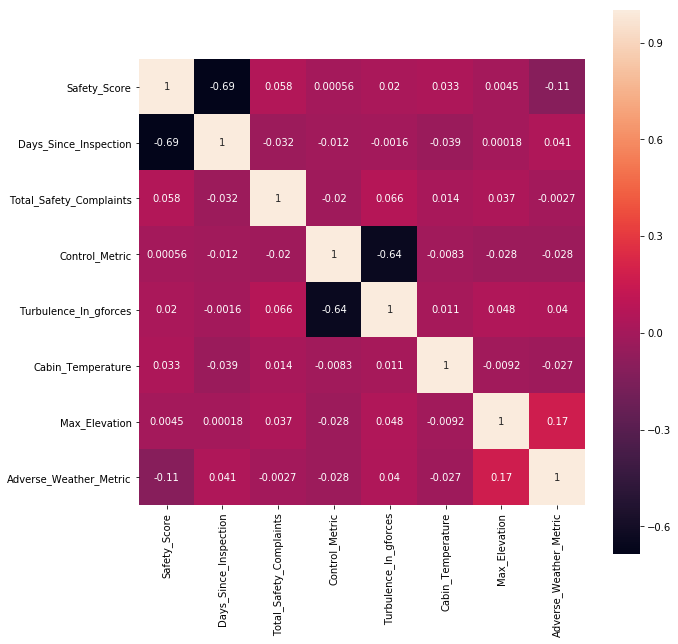

In [22]:
plt.figure(figsize=(10, 10))
cor=df.corr()
sns.heatmap(cor,annot=True,square=True,)

In [42]:
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
print(IQR)

Safety_Score                  21.917808
Days_Since_Inspection          4.000000
Total_Safety_Complaints        1.428022
Control_Metric                16.408387
Turbulence_In_gforces          1.371344
Cabin_Temperature              1.430359
Max_Elevation              12623.004605
Adverse_Weather_Metric         1.769229
dtype: float64


**The "interquartile range", abbreviated "IQR", is just the width of the box in the box-and-whisker plot. That is, IQR = Q3 – Q1 . The IQR can be used as a measure of how spread-out the values are.**

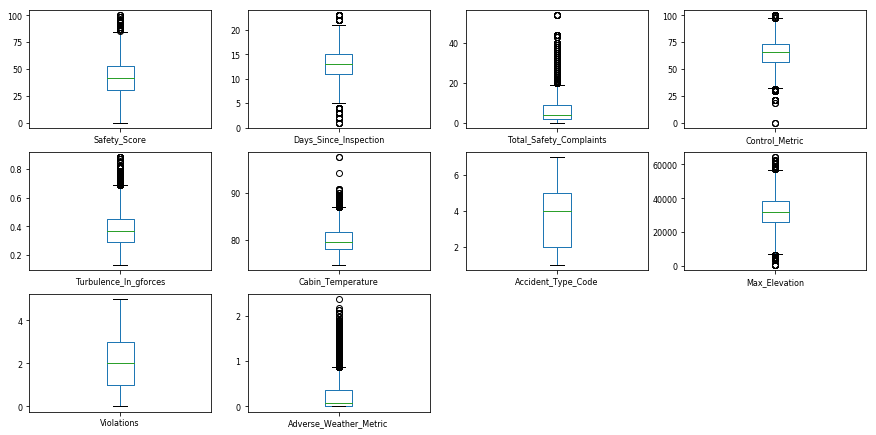

In [24]:
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, legend=True, 
        figsize=(15,10), fontsize=8)
plt.show()

In [25]:
from scipy.special import boxcox1p

In [26]:
df["Total_Safety_Complaints"] =boxcox1p(df["Total_Safety_Complaints"],0.1)

In [27]:
from sklearn.preprocessing import power_transform
df['Adverse_Weather_Metric'] = power_transform(np.array(df['Adverse_Weather_Metric']).reshape(-1,1))
df['Cabin_Temperature'] = power_transform(np.array(df['Cabin_Temperature']).reshape(-1,1))
df['Turbulence_In_gforces'] = power_transform(np.array(df['Turbulence_In_gforces']).reshape(-1,1))

C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2921: FutureWarning: The default value of 'method' will change from 'box-cox' to 'yeo-johnson' in version 0.23. Set the 'method' argument explicitly to silence this warning in the meantime.
  FutureWarning)
C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2921: FutureWarning: The default value of 'method' will change from 'box-cox' to 'yeo-johnson' in version 0.23. Set the 'method' argument explicitly to silence this warning in the meantime.
  FutureWarning)
C:\Users\Srinivas Vadlamani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2921: FutureWarning: The default value of 'method' will change from 'box-cox' to 'yeo-johnson' in version 0.23. Set the 'method' argument explicitly to silence this warning in the meantime.
  FutureWarning)


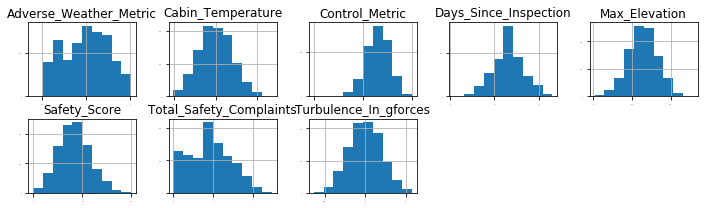

In [28]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12), layout=(7, 5))
plt.show()

In [29]:
df.Severity.value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

In [30]:
X= df.loc[:,~df.columns.isin(['Severity'])]
y= df['Severity']

In [31]:
X_dummy = pd.get_dummies(X,drop_first=True,prefix_sep='_')

In [32]:
# Try lightgbm
# Initializing the LightGBM model
gbm_model = lgb.LGBMClassifier(objective='multiclass')

# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.10, stratify=y)
# Fitting LightGBM model
gbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss', early_stopping_rounds=150)

[1]	valid_0's multi_logloss: 1.23978
Training until validation scores don't improve for 150 rounds
[2]	valid_0's multi_logloss: 1.13565
[3]	valid_0's multi_logloss: 1.05005
[4]	valid_0's multi_logloss: 0.977366
[5]	valid_0's multi_logloss: 0.913734
[6]	valid_0's multi_logloss: 0.857538
[7]	valid_0's multi_logloss: 0.807683
[8]	valid_0's multi_logloss: 0.763307
[9]	valid_0's multi_logloss: 0.722038
[10]	valid_0's multi_logloss: 0.685001
[11]	valid_0's multi_logloss: 0.650697
[12]	valid_0's multi_logloss: 0.619884
[13]	valid_0's multi_logloss: 0.592294
[14]	valid_0's multi_logloss: 0.566646
[15]	valid_0's multi_logloss: 0.537861
[16]	valid_0's multi_logloss: 0.512378
[17]	valid_0's multi_logloss: 0.491373
[18]	valid_0's multi_logloss: 0.468038
[19]	valid_0's multi_logloss: 0.448767
[20]	valid_0's multi_logloss: 0.433837
[21]	valid_0's multi_logloss: 0.414548
[22]	valid_0's multi_logloss: 0.397394
[23]	valid_0's multi_logloss: 0.382114
[24]	valid_0's multi_logloss: 0.369071
[25]	valid_0's

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
y_pred_probs = gbm_model.predict_proba(X_test)
# plot_roc_curve(y_test, y_pred_probs, curves=['each_class'], figsize=(10,7))
# plt.show()

In [34]:
test = pd.read_csv("test.csv")

In [35]:
test['Accident_Type_Code'] = test['Accident_Type_Code'].astype(object)
test['Violations'] =test['Violations'].astype(object)

In [36]:
test2 = pd.get_dummies(test,drop_first=True,prefix_sep='_')
# Create submission file
test1=test2.drop(['Accident_ID'],axis=1)
predictions = gbm_model.predict(test1)

In [43]:
submission_df = pd.DataFrame({'Accident_ID':test['Accident_ID'],'Severity':predictions})
submission_df.to_csv("vadlamani_srinivas.csv", index=False) 